# Developing Optimisers in Python
Jay Parfitt 2013962

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1
Implement the functions

Global counter for the function evaluations

In [ ]:
funcCounters = {'f':0, 'g1':0, 'g2':0, 'g3':0, 'g4':0}

Defining the functions

In [ ]:
#f(x)
def f(x):
  global funcCounters
  funcCounters['f'] += 1
  return x[0]**2 * x[1] * (2 + x[2])

#g1(x)
def g1(x):
  global funcCounters
  funcCounters['g1'] += 1
  return 1 - (x[1]**2 * x[2]) / (71785 * x[0]**4)

#g2(x)
def g2(x):
  global funcCounters
  funcCounters['g2'] += 1
  part1 = 4 * x[1]**2 - x[0] * x[1]
  part2 = 12566 * (x[1] * x[0]**3 - x[0]**4)
  part3 = 1 / (5108 * x[0]**2)
  return part1 / part2 + part3 - 1

#g3(x)
def g3(x):
  global funcCounters
  funcCounters['g3'] += 1
  return 1 - (140.45 * x[0]) / (x[1]**2 * x[2])

#g4(x)
def g4(x):
  global funcCounters
  funcCounters['g4'] += 1
  return ((x[0] + x[1]) / 1.5) - 1

In [ ]:
x = np.array([0.42, 0.9, 7])
print("Objective function output: ", f(x))
print("First contraint function output: ", g1(x))
print("Second contraint function output: ", g2(x))
print("Third contraint function output: ", g3(x))
print("Fourth contraint function output: ", g4(x))

Objective function output:  1.4288399999999999
First contraint function output:  0.9974616459784045
Second contraint function output:  -0.9924857111736846
Third contraint function output:  -9.403703703703702
Fourth contraint function output:  -0.12


## Task 2
Implement Random Search

### Feasability function
Checks if a solution x satisfies all contraintes and bounds

In [ ]:
def isFeasable(x):
  return all([
      g1(x) <= 0,
      g2(x) <= 0,
      g3(x) <= 0,
      g4(x) <= 0,
      0.05 <= x[0] <= 2,
      0.25 <= x[1] <= 1.3,
      2 <= x[2] <= 15
  ])

### Random Search function


In [ ]:
def randomSearch(maxEvals=500, randomSeed=42):
  # Setting random seed
  np.random.seed(randomSeed)
  # initialising best solution
  bestX, bestVal = None, float('inf')
  results = []

  # setting the bounds
  for _ in range(maxEvals):
    x = np.array([
        np.random.uniform(0.05, 2),
        np.random.uniform(0.25, 1.3),
        np.random.uniform(2, 15)
    ])

    # rejects and regenerates if constraints are not satisfied
    if isFeasable(x):
      val = f(x)
      results.append(val)
      if val < bestVal:
        bestVal = val
        bestX = x

  return bestX, bestVal

In [ ]:
bestX, bestVal = randomSearch()
print("Best solution: ", bestX)
print("Best value: ", bestVal)

Best solution:  [ 0.07144187  0.39372991 13.70024234]
Best value:  0.0315507976151424


## Task 3
Implement the simulated annealing method

### Generate Initial Solution

Inital solution is also required to be feasable to allow the algorithm to start from a valid point

In [ ]:
def generateInitialSolution():
  while True:
    # generates random solution within bounds
    x = np.array([
        np.random.uniform(0.05, 2),
        np.random.uniform(0.25, 1.3),
        np.random.uniform(2, 16)
    ])

    # checks if it's feasable
    if isFeasable(x):
      return x

### Simulated Annealing function

In [ ]:
def simulatedAnnealing(maxEvals=500, initalTemp=100, coolingRate=0.95, randomSeed=42):
  np.random.seed(randomSeed)
  x = generateInitialSolution()

  bestX, bestVal = x, f(x)
  currentX, currentVal = x, f(x)
  temp = initalTemp

  for _ in range(maxEvals):
    neighbour = currentX + np.random.uniform(-0.1, 0.1, size=3)
    neighbour[0] = np.clip(neighbour[0], 0.05, 2)
    neighbour[1] = np.clip(neighbour[1], 0.25, 1.3)
    neighbour[2] = round(np.clip(neighbour[2], 2, 15))

    if isFeasable(neighbour):
      neighbourVal = f(neighbour)
      delta = neighbourVal - currentVal

      # accepts neighbour based on SA criteria
      if delta < 0 or np.exp(-delta / temp) > np.random.rand():
        currentX, currentVal = neighbour, neighbourVal
        if neighbourVal < bestVal:
          bestX, bestVal = neighbour, neighbourVal

    temp *= coolingRate

  return bestX, bestVal


In [ ]:
initialSolution = generateInitialSolution()
print("Initial solution: ", initialSolution)
print("Initial value: ", f(initialSolution))

bestX, bestVal = simulatedAnnealing()
print("Best solution: ", bestX)
print("Best value: ", bestVal)

Initial solution:  [0.07151097 0.6869617  8.73881812]
Initial value:  0.03772543841187907
Best solution:  [0.06300766 0.6387352  5.        ]
Best value:  0.01775029608844368


## Task 4
Performance Evaluation

### Evaluation

Evaluate RS snf SA over 21 runs

In [ ]:
def evalutaion(repitions=21, maxEvals=500):
  rsResults =[]
  saResults = []
  for _ in range(repitions):
    _, bestVal = randomSearch(maxEvals=maxEvals, randomSeed=np.random.randint(1000))
    rsResults.append(bestVal)
    _, bestVal = simulatedAnnealing(maxEvals=maxEvals, initalTemp=100,
                                    coolingRate=0.95, randomSeed=np.random.randint(1000))
    saResults.append(bestVal)

  return rsResults, saResults

### Visualization

Visualize the performance of RS and SA

In [ ]:
def visualization(rsResults, saResults):
  plt.boxplot([rsResults, saResults], labels=['Random Search', 'Simulated Annealing'])
  plt.title('Performance Comparison')
  plt.ylabel('Objective Function Value')
  plt.show()


### Comparison

Statistical comparison of RS and SA results

In [ ]:
from scipy.stats import ttest_ind

def comparison(rsResults, saResults):
  tStat, pValue = ttest_ind(rsResults, saResults)
  print(f"T-Test Results: t= {tStat:.3f}, p= {pValue:.3f}")

### Conclusion


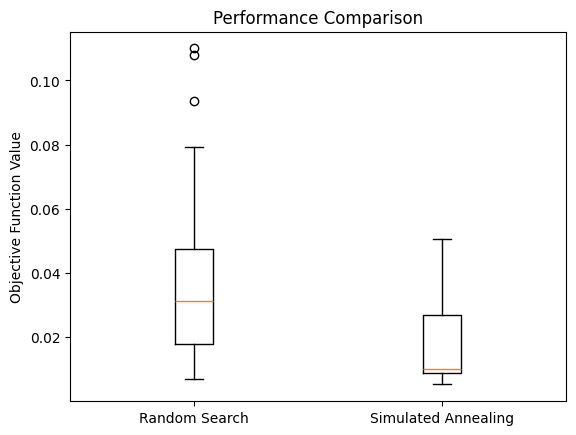

T-Test Results: t= 3.042, p= 0.004


In [ ]:
rsResults, saResults = evalutaion(repitions=21, maxEvals=500)
visualization(rsResults, saResults)
comparison(rsResults, saResults)

**Random Search**
- Wider range and higher variability with the results
- Outliners present above 0.08, showing RS occasionally produces poor solutions
- Median is higher compared to SA

**Simulated Annealing**
- Tighlty clustered indicating better consistency
- Lower median, with a smaller spread than RS
- SA consistantly produced better solutions

**T-Test Results**
t-value = 3.042:
- A large difference between the means of the two distributions
- A larger t-value signifies a greater difference in performance
p-value= 0.004:
- Shows that SA performs better than RS

**Conclusion**

RS has higher variability and occasionaly produces suboptimal solutions. SA is more robust, delivering consistently better solutions within the feasable space